<a href="https://colab.research.google.com/gist/idyeetya/d316c86ec4049c7c01355bd43c71c1b6/stock_nlp_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using BERT for sentiment analysis in stock reviews**

In [ ]:
!pip install transformers
import os
import gdown
import torch
import numpy as np
import transformers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

% matplotlib inline

# gdown.download('https://drive.google.com/uc?id=1q4U2gVY9tWEPdT6W-pdQpKmo152QqWLE', 'finance_train.csv', True)
# gdown.download('https://drive.google.com/uc?id=1nIBqAsItwVEGVayYTgvybz7HeK0asom0', 'finance_test.csv', True)

!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv'

def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

print ("Train and Test Files Loaded as train.csv and test.csv")

LABEL_MAP = {0 : "negative", 1 : "neutral", 2 : "positive"}
NONE = 4 * [None]
RND_SEED=2020




     |████████████████████████████████| 2.6 MB 9.4 MB/s 
     |████████████████████████████████| 3.3 MB 41.5 MB/s 
     |████████████████████████████████| 636 kB 62.2 MB/s 
     |████████████████████████████████| 895 kB 54.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
--2021-07-29 15:42:50--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29264 (29K) [application/vnd.ms-excel]
Saving to: ‘finance_test.csv’

finance_test.csv    100%[===================>]  28.58K  --.-KB/s    in 0s      

2021-07-29 15:42:50 (1

In [ ]:
df_train = get_finance_train()
df_test = get_finance_test()

In [ ]:
sentences = df_train["Sentence"].values
labels = df_train["Label"].values

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)

In [ ]:
print(tokenizer.vocab_size)

30522


In [ ]:
print(sentences[0])
tokenized_sentence = (tokenizer.tokenize(sentences[0]))
print(tokenized_sentence)

Autotank Group is part of Aspo 's Systems Division .
['auto', '##tan', '##k', 'group', 'is', 'part', 'of', 'as', '##po', "'", 's', 'systems', 'division', '.']


In [ ]:
print(tokenizer.convert_tokens_to_ids(tokenized_sentence))

[8285, 5794, 2243, 2177, 2003, 2112, 1997, 2004, 6873, 1005, 1055, 3001, 2407, 1012]


In [ ]:
sentences_with_special_tokens = []
for sentence in sentences:
  sentence = "[CLS] " + sentence + " [SEP]"
  sentences_with_special_tokens.append(sentence)
print(sentences_with_special_tokens[0])

[CLS] Autotank Group is part of Aspo 's Systems Division . [SEP]


In [ ]:
tokenized_texts = []
for sentence in sentences_with_special_tokens:
  sentence = tokenizer.tokenize(sentence)
  tokenized_texts.append(sentence)
print(tokenized_texts[0])

['[CLS]', 'auto', '##tan', '##k', 'group', 'is', 'part', 'of', 'as', '##po', "'", 's', 'systems', 'division', '.', '[SEP]']


In [ ]:
input_ids = []
for sentence in tokenized_texts:
  sentence = tokenizer.convert_tokens_to_ids(sentence)
  input_ids.append(sentence)
print(input_ids[0])

[101, 8285, 5794, 2243, 2177, 2003, 2112, 1997, 2004, 6873, 1005, 1055, 3001, 2407, 1012, 102]


In [ ]:
input_ids = pad_sequences(input_ids, 
                          maxlen=128,
                          dtype="long",
                          truncating="post", 
                          padding="post")
print(input_ids[0])

[ 101 8285 5794 2243 2177 2003 2112 1997 2004 6873 1005 1055 3001 2407
 1012  102    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
attention_masks = []

for sentence in input_ids:
  sentence = [float(i>0) for i in sentence]
  attention_masks.append(sentence)
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(input_ids, labels, test_size = 0.15, random_state=RND_SEED)

In [ ]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, test_size = 0.15, random_state=RND_SEED)

In [ ]:
train_inputs = torch.tensor(np.array(X_train));
validation_inputs = torch.tensor(np.array(X_val));
train_masks = torch.tensor(np.array(train_masks));
validation_masks = torch.tensor(np.array(validation_masks));
train_labels = torch.tensor(np.array(y_train));
validation_labels = torch.tensor(np.array(y_val));

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels);
train_sampler = RandomSampler(train_data); 
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size);
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels);
validation_sampler = SequentialSampler(validation_data); 
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size);

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 3,    
    output_attentions = False, 
    output_hidden_states = False, 
);


model.cuda();

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

'Tesla T4'

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )
epochs = 4

In [ ]:

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

training_loss = []
validation_loss = []
training_stats = []
for epoch_i in range(0, epochs):
    print('Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training the model')
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 20 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)  

        model.zero_grad()    


        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]

        total_train_loss += loss.item()


        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    print("  Average training loss: {0:.2f}".format(avg_train_loss))

    print("Evaluating on Validation Set")
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    
    
    print("Validation Loss: {0:.2f}".format(avg_val_loss))
    

    training_loss.append(avg_train_loss)
    validation_loss.append(avg_val_loss)
    
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy
            
        }
    )
    
print("Training complete!")

Epoch 1 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.64
Evaluating on Validation Set
Validation Accuracy: 0.90
Validation Loss: 0.35
Epoch 2 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.22
Evaluating on Validation Set
Validation Accuracy: 0.94
Validation Loss: 0.18
Epoch 3 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.09
Evaluating on Validation Set
Validation Accuracy: 0.96
Validation Loss: 0.14
Epoch 4 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.04
Evaluating on Validation Set
Validation Accuracy: 0.96
Validation Loss: 0.14
Training complete!


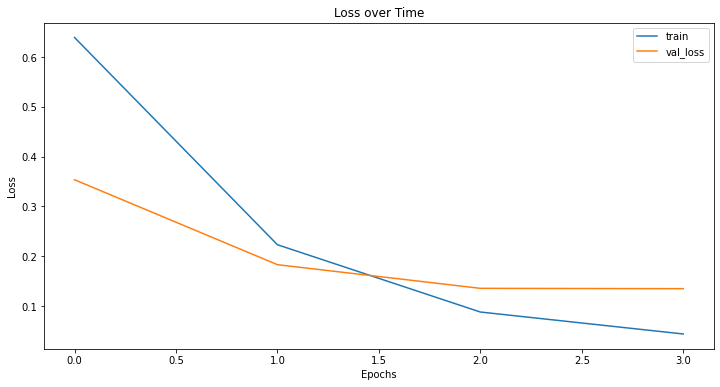

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(training_loss, label = "train")
plt.plot(validation_loss, label = "val_loss")

plt.legend()
plt.show()

In [ ]:
### YOUR CODE HERE
test_sentences = df_test["Sentence"].values
test_labels = df_test["Label"].values

### END CODE

In [ ]:
test_input_ids, test_attention_masks = [], []

test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]

tokenized_test_sentences = [tokenizer.tokenize(sent) for sent in test_sentences]

test_input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_test_sentences]

test_input_ids = pad_sequences(test_input_ids, 
                               maxlen=128, 
                               dtype="long",
                               truncating="post", 
                               padding="post")

for sequence in test_input_ids:
  mask = [float(i>0) for i in sequence]
  test_attention_masks.append(mask)

In [ ]:
batch_size = 32  
test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

  
print ('Test Accuracy: {:.2%}'.format(flat_accuracy(logits, label_ids)))



Predicting labels for 227 test sentences...
Test Accuracy: 100.00%
